# Séries temporelles

Ici on fait tout le code pour étudier les séries temporelles.

Comment étudier une série temporelle ?  
1/	Visualiser la série : saisonnalité ? comportement récurrent ?  
2/	1ère transformation (par exemple transformation en log)  
3/	Est-ce que la série est stationnaire ? (test ADF, test KPSS)  
        - OUI : modèle ARMA  
        - NON : modèle ARIMA -> si on a un problème de racine unitaire, on va faire une transformation sur la série afin d’enlever ce problème de racine unitaire. On aura la série transformée, et si elle est stationnaire on pourra regarder p et q (critère bayésien).  
4/	Processus classique de série temporelle : prévision à t+1, t+2, etc.  

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 1. Données trafic aérien - France

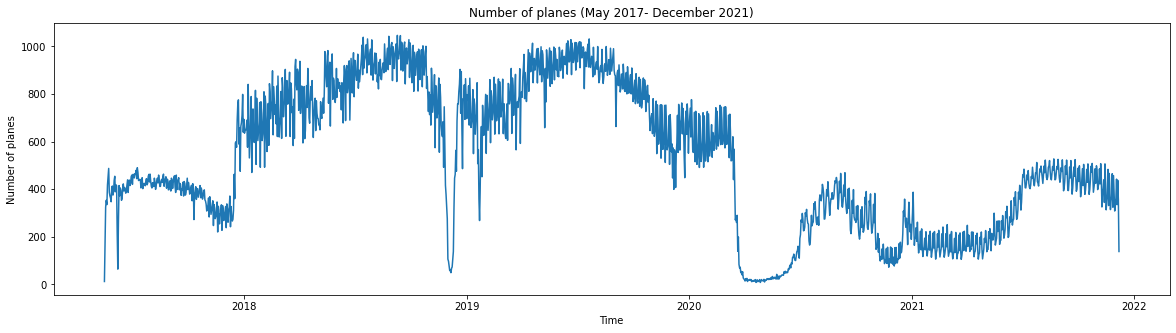

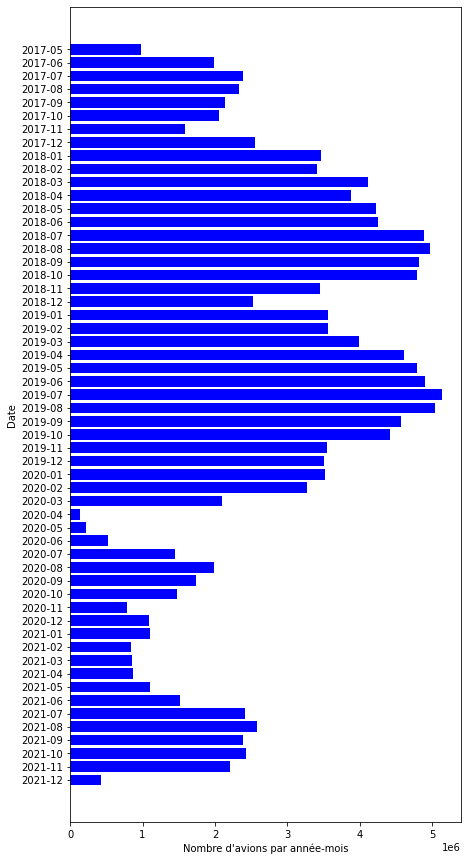

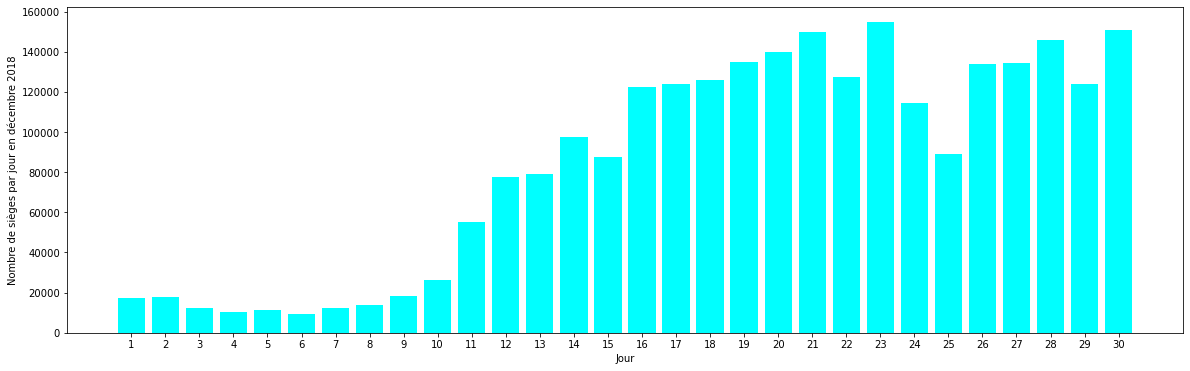

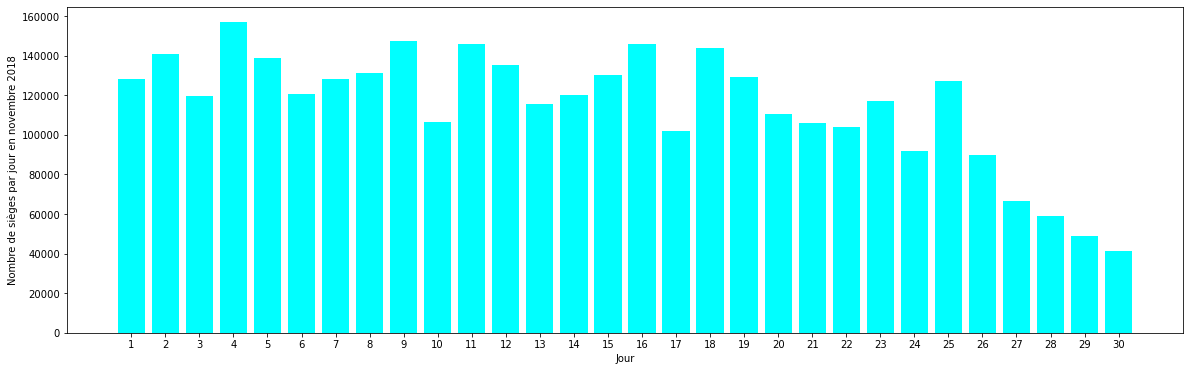

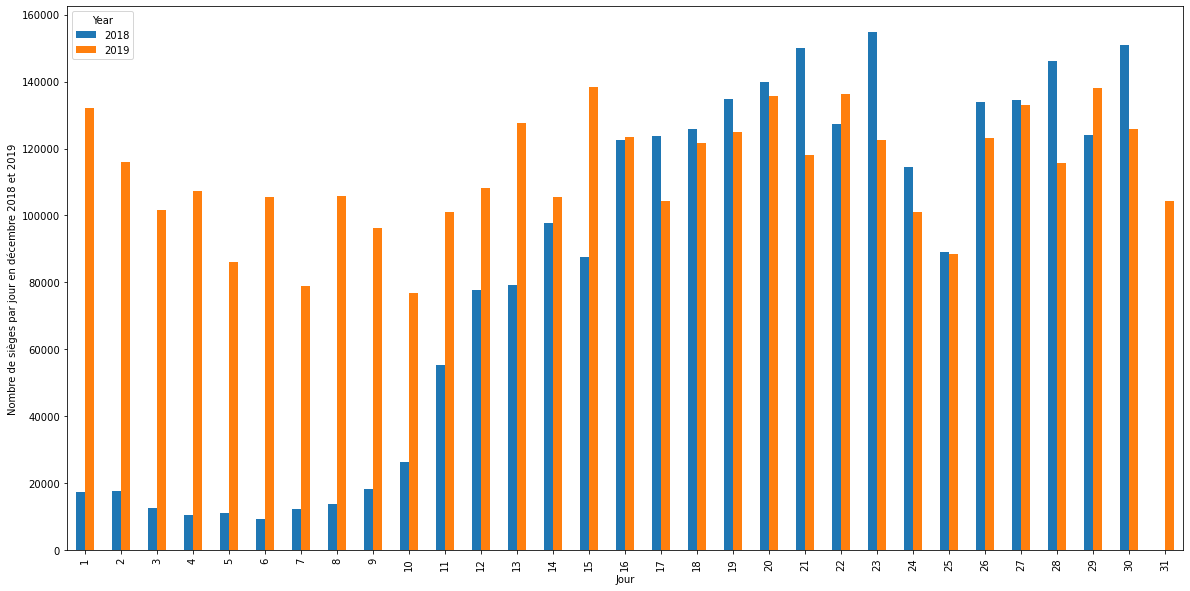

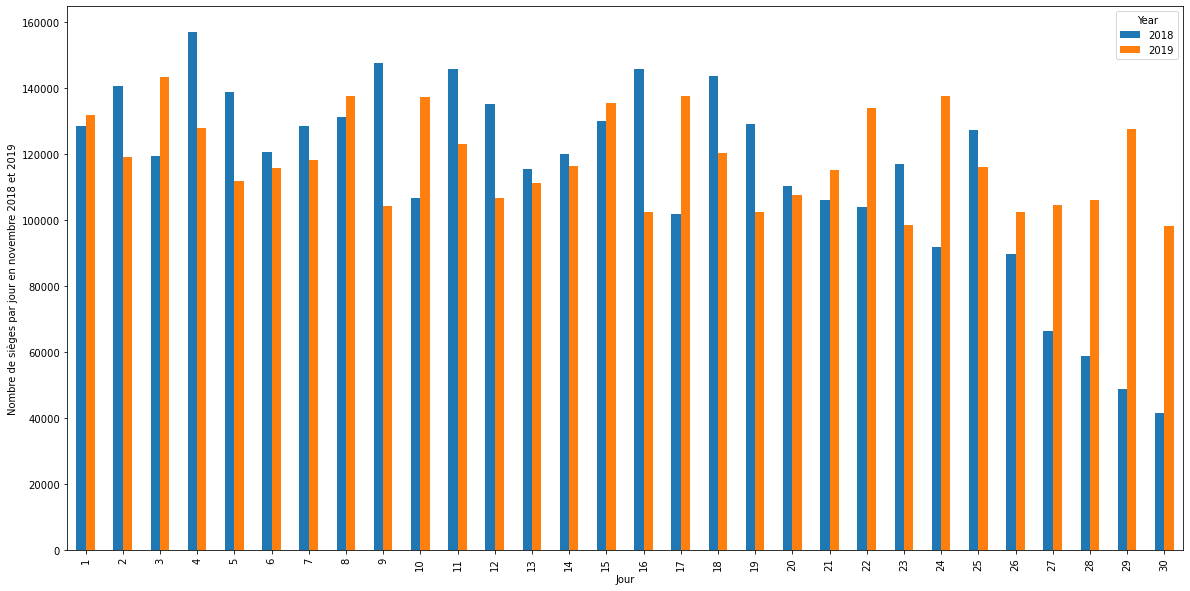

C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/2747778951.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imput_obs_2019["Year"]=2018
C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/2747778951.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imput_obs_2019["sheduled_time_start"] = pd.to_datetime(df_imput_obs_2019[['Year', 'Month', 'Day']])
C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/2747778951.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

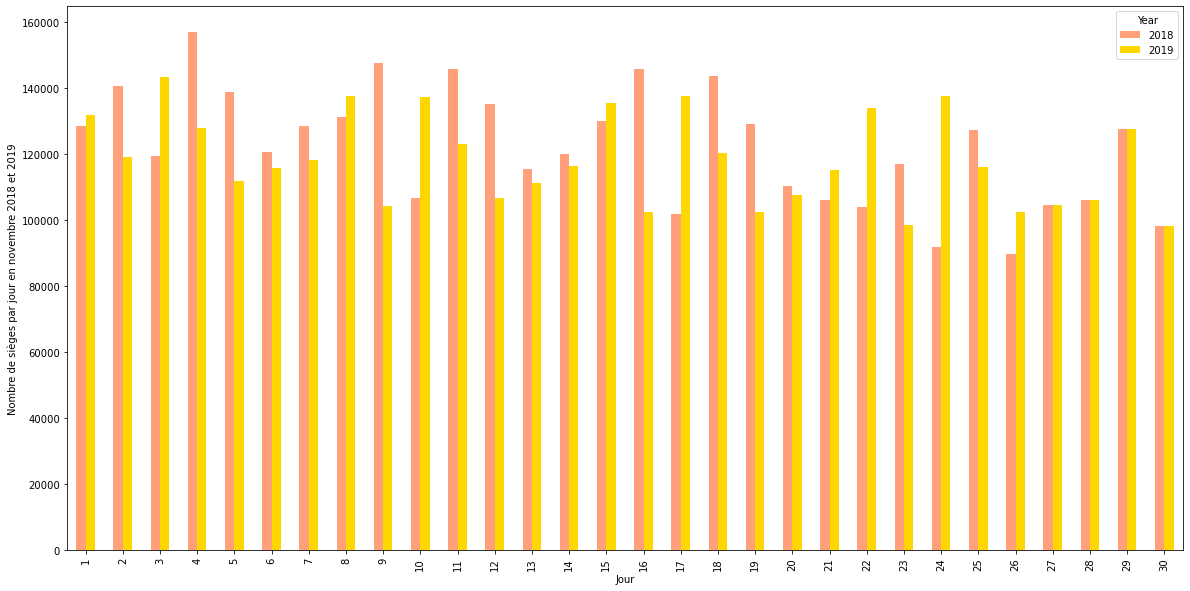

C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/4036887885.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_imput_obs_2019["Year"]=2018
C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/4036887885.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_imput_obs_2019["sheduled_time_start"] = pd.to_datetime(df2_imput_obs_2019[['Year', 'Month', 'Day']])
C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/4036887885.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

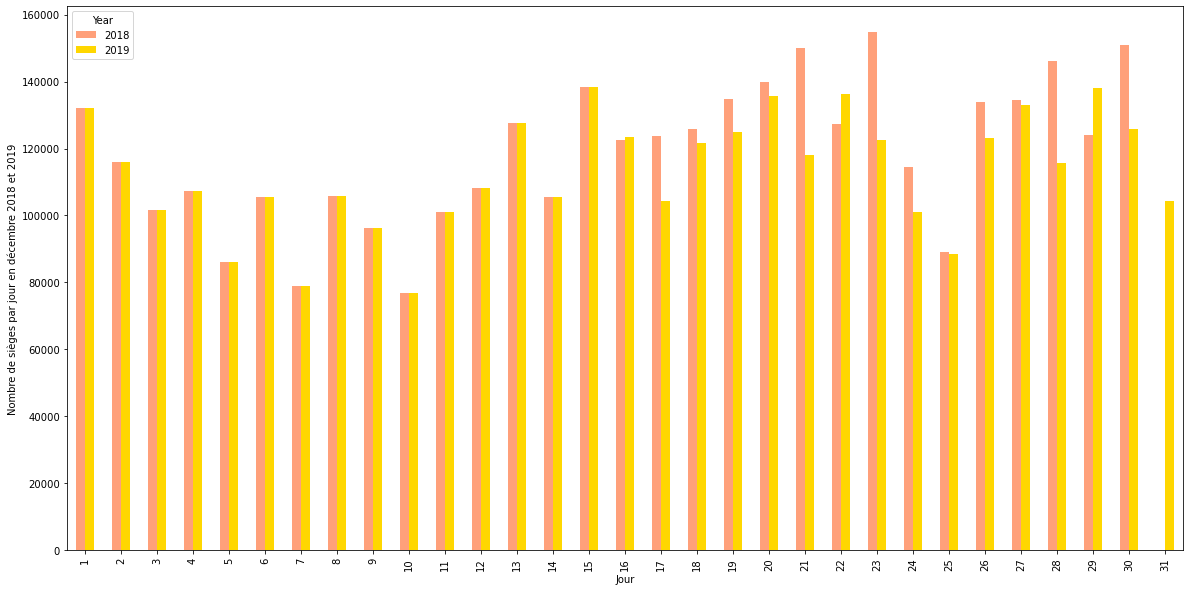

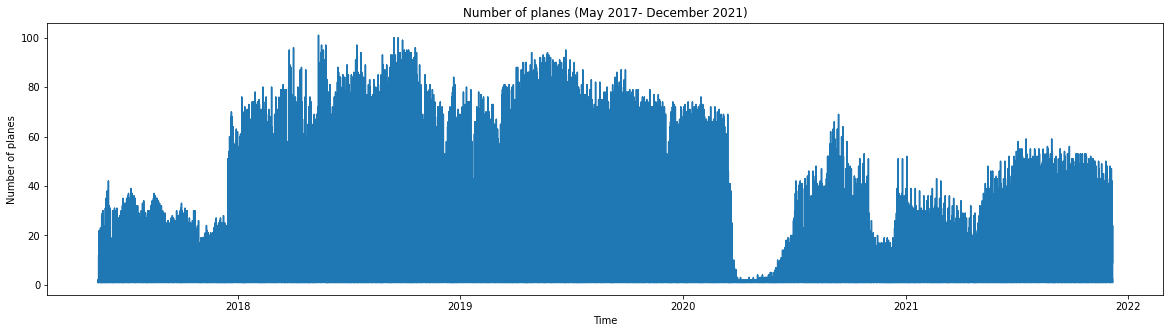

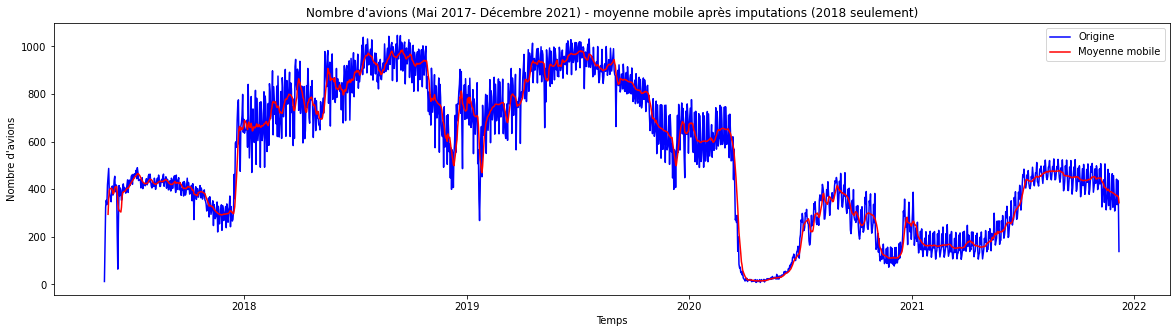

C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/4207640472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imput_obs_2017["Year"]=2017
C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/4207640472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imput_obs_2017["sheduled_time_start"] = pd.to_datetime(df_imput_obs_2017[['Year', 'Month', 'Day']])
C:\Users\Clemence\AppData\Local\Temp/ipykernel_63928/4207640472.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

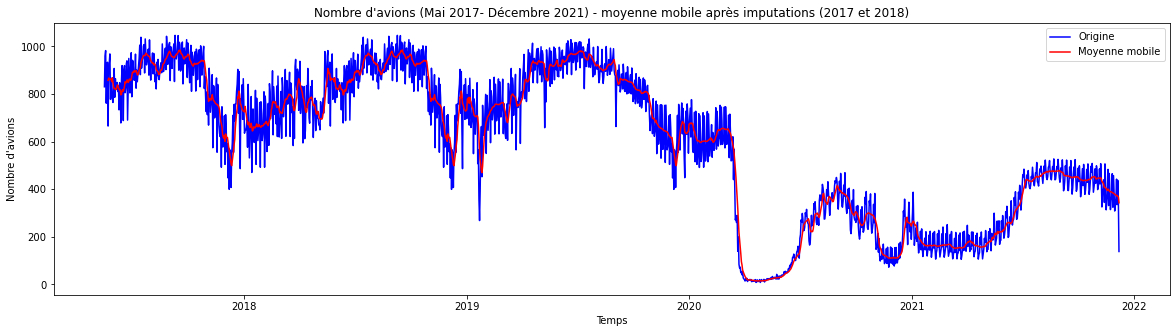

In [20]:
#pour importer le dataframe avec les valeurs manquantes traitées
%run "Valeurs manquantes.ipynb"

In [21]:
#la base avec les imputations de nov-déc 2018 et les imputations de 2017
df_air_traffic_imput2

,country_origin,citydest,sheduled_time_start,seats,number_planes,Year,Month,Day,Year-Month
64344,Ireland,Paris,2017-05-16,818.0,5,2017,5,16,2017-05
64478,Reunion,Paris,2017-05-16,1751.0,4,2017,5,16,2017-05
64479,Portugal,Nice,2017-05-16,114.0,1,2017,5,16,2017-05
64480,France,Clermont-Ferrand,2017-05-16,100.0,1,2017,5,16,2017-05
64481,United Kingdom,Carcassonne,2017-05-16,189.0,1,2017,5,16,2017-05
...,...,...,...,...,...,...,...,...,...
265659,France,Toulouse,2021-12-07,1481.0,9,2021,12,7,2021-12
265644,Portugal,Basel,2021-12-07,164.0,1,2021,12,7,2021-12
265662,United Arab Emirates,Paris,2021-12-07,1706.0,2,2021,12,7,2021-12
265664,Denmark,Paris,2021-12-07,234.0,1,2021,12,7,2021-12


### 1.1. Moyenne mobile

#### Sur la base sans le traitement des valeurs manquantes

In [4]:
# On commence par visualiser la table
df_air_traffic_france = pd.read_csv('france_air_traffic_210712.csv')
df_air_traffic_france['sheduled_time_start']=pd.to_datetime(df_air_traffic_france['sheduled_time_start'])
df_air_traffic_france.head(5)

,country_origin,citydest,sheduled_time_start,seats,number_planes
0,Albania,Nantes,2021-10-12,189.0,1
1,Albania,Paris,2017-08-17,189.0,1
2,Albania,Paris,2017-08-19,189.0,1
3,Albania,Paris,2017-08-22,189.0,1
4,Albania,Paris,2020-08-12,148.0,1


Text(0, 0.5, 'Number of planes')

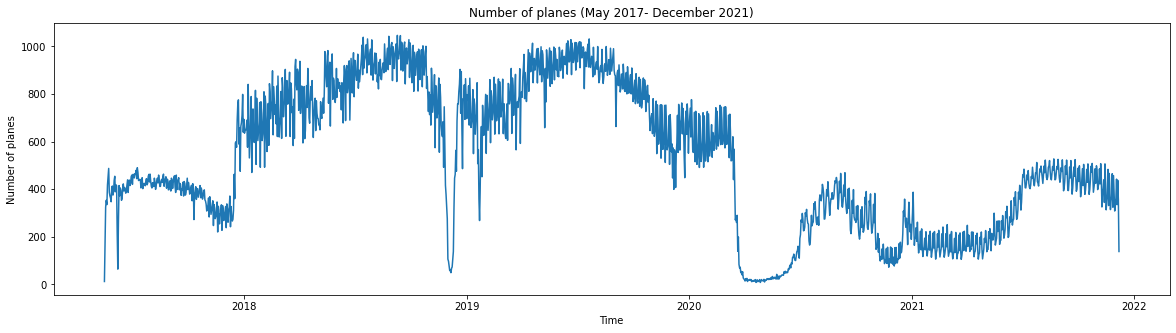

In [6]:
df_air_traffic_france4=df_air_traffic_france.groupby('sheduled_time_start').sum()
df_air_traffic_france4=df_air_traffic_france4.reset_index()
x=df_air_traffic_france4["sheduled_time_start"]
y=df_air_traffic_france4["number_planes"]
fig = plt.figure(1, figsize=(20, 5))
plt.plot(x, y)
plt.title('Number of planes (May 2017- December 2021)')
plt.xlabel('Time')
plt.ylabel('Number of planes')

In [10]:
df_air_traffic_france5 = df_air_traffic_france4['number_planes']

Text(0, 0.5, 'Number of planes')

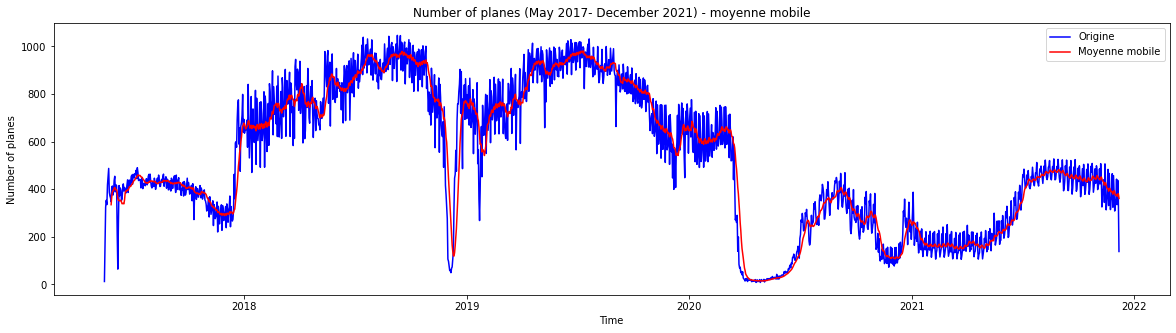

In [11]:
df_air_traffic_france4=df_air_traffic_france.groupby('sheduled_time_start').sum()
df_air_traffic_france4=df_air_traffic_france4.reset_index()

x=df_air_traffic_france4["sheduled_time_start"]
y=df_air_traffic_france4["number_planes"]
z=rolling_mean = df_air_traffic_france5.rolling(window = 12).mean()

fig = plt.figure(1, figsize=(20, 5))
plt.plot(x,y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title('Number of planes (May 2017- December 2021) - moyenne mobile')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Number of planes')

Text(0, 0.5, 'Number of planes')

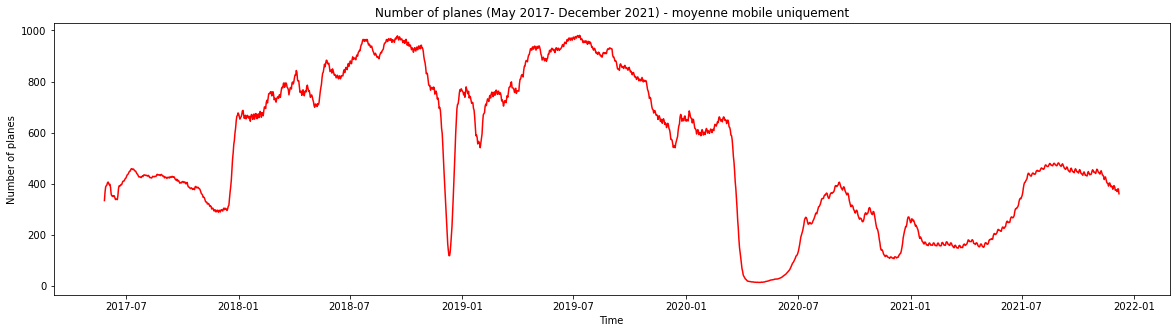

In [12]:
fig = plt.figure(1, figsize=(20, 5))
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title('Number of planes (May 2017- December 2021) - moyenne mobile uniquement')
plt.xlabel('Time')
plt.ylabel('Number of planes')

Text(0, 0.5, 'Number of seats')

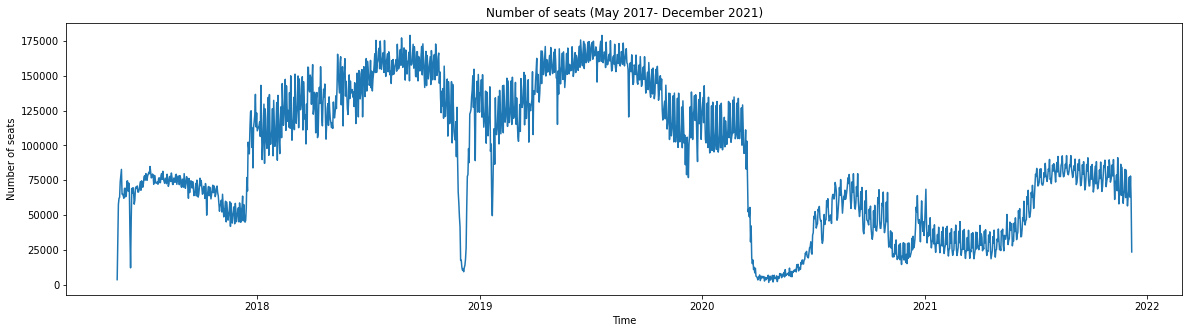

In [13]:
df_air_traffic_france4=df_air_traffic_france.groupby('sheduled_time_start').sum()
df_air_traffic_france4=df_air_traffic_france4.reset_index()
x=df_air_traffic_france4["sheduled_time_start"]
y=df_air_traffic_france4["seats"]
fig = plt.figure(1, figsize=(20, 5))
plt.plot(x, y)
plt.title('Number of seats (May 2017- December 2021)')
plt.xlabel('Time')
plt.ylabel('Number of seats')

#### Sur la base avec traitement des valeurs manquantes

Text(0, 0.5, "Nombre d'avions")

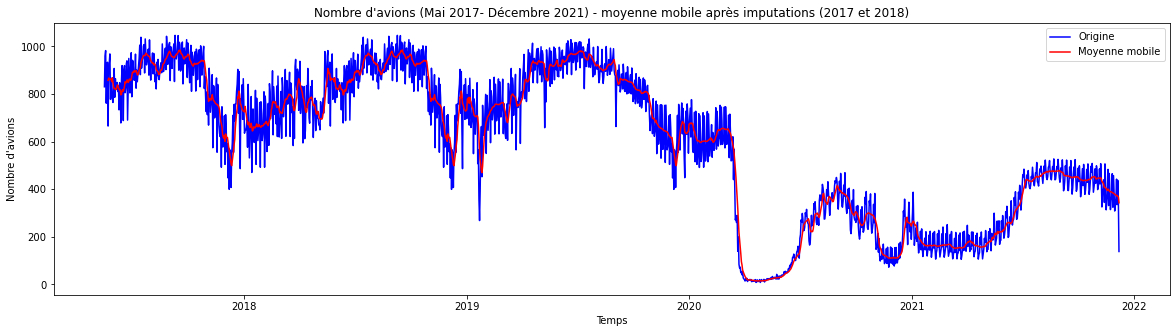

In [7]:
#on regarde la série temporelle et la moyenne mobile du nombre d'avions après cette nouvelle imputation

df_air_traffic_imput2_grouped = df_air_traffic_imput2.groupby('sheduled_time_start').sum()
df_air_traffic_imput2_avions = df_air_traffic_imput2_grouped['number_planes']
df_air_traffic_imput2_grouped.reset_index(inplace=True)

x = df_air_traffic_imput2_grouped["sheduled_time_start"]
y = df_air_traffic_imput2_grouped["number_planes"]
z = rolling_mean = df_air_traffic_imput2_avions.rolling(window = 7).mean()

fig = plt.figure(1, figsize=(20, 5))
plt.plot(x,y, color = 'blue', label = 'Origine')
plt.plot(x, z, color = 'red', label = 'Moyenne mobile')
plt.title("Nombre d'avions (Mai 2017- Décembre 2021) - moyenne mobile après imputations (2017 et 2018)")
plt.legend(loc = 'best')
plt.xlabel('Temps')
plt.ylabel("Nombre d'avions")

### 1.2. Test - Etude de la tendance et de la saisonnalité 

In [26]:
#df_air_traffic_imput2_date c'est la base df_air_traffic_imput2 dans laquelle on a sommé les avions et sièges par jour de départ

df_air_traffic_imput2_date = df_air_traffic_imput2.groupby('sheduled_time_start').agg({'seats':'sum','number_planes':'sum'})
df_air_traffic_imput2_date

,seats,number_planes
sheduled_time_start,,
2017-05-16,137671.0,830
2017-05-17,158894.0,959
2017-05-18,163676.0,982
2017-05-19,129127.0,761
2017-05-20,151465.0,869
...,...,...
2021-12-03,77261.0,442
2021-12-04,62891.0,335
2021-12-05,78047.0,437


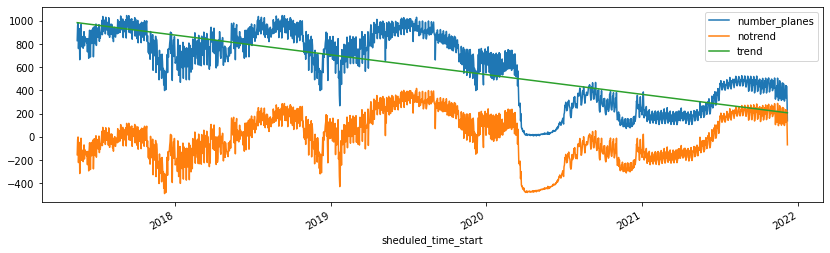

In [11]:
# but: on enlève une tendance linéaire

from statsmodels.tsa.tsatools import detrend

notrend = detrend(df_air_traffic_imput2_date['number_planes'])
df_air_traffic_imput2_date["notrend"] = notrend
df_air_traffic_imput2_date["trend"] = df_air_traffic_imput2_date['number_planes'] - notrend
df_air_traffic_imput2_date.plot(y=["number_planes", "notrend", "trend"], figsize=(14,4));

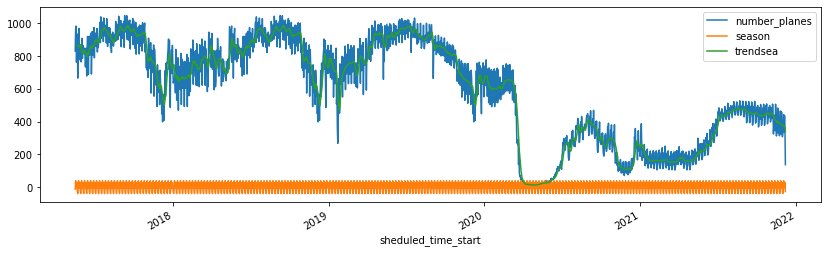

In [15]:
# retirer la saisonnalité 

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df_air_traffic_imput2_date["number_planes"].values.ravel(), period=7, two_sided=False)
df_air_traffic_imput2_date["season"] = res.seasonal
df_air_traffic_imput2_date["trendsea"] = res.trend
df_air_traffic_imput2_date.plot(y=["number_planes", "season", "trendsea"], figsize=(14,4));

C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


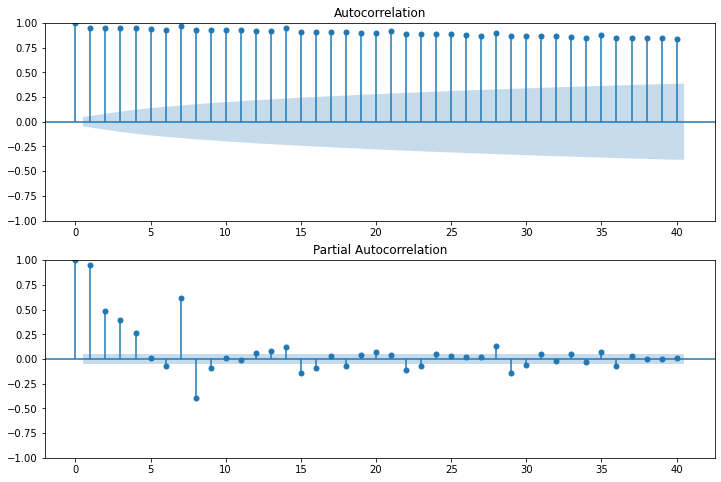

In [14]:
# autocorrélation

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_air_traffic_imput2_date["number_planes"], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_air_traffic_imput2_date["number_planes"], lags=40, ax=ax2);